In [99]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.io.wavfile import write

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['legend.loc'] = 'best'

# The envelope detector implemented using the Hilbert transform
# See: https://blog.csdn.net/m0_37262671/article/details/125303404
def get_envelope(x, n=None):
    analytic_signal = hilbert(x, N=n)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def butter_lowpass(cutoff_frequency, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff_frequency, fs, order=4):
    b, a = butter_lowpass(cutoff_frequency, fs, order=order)
    y = lfilter(b, a, data)
    return y  

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# produce AWGN noise
def awgn(x, snr_dB): # SNR in dB
    snr = 10**(snr_dB/10.0)
    xpower = np.sum(x**2)/len(x)    # power of input signal
    npower = xpower / snr        # power of noise calculated by SNR
    # gaussian noise
    noise = np.random.randn(len(x)) * np.sqrt(npower)
    return noise, npower

def calculate_max_p2p(x):
    return np.max(np.abs(x)) - np.min(np.abs(x))

def write_wav(x:np.array, filename = 'output.wav', fs = 44100):
    write(filename, fs, x.astype(np.int16))

    

## Generate FM Signal

In [87]:
from scipy.signal import butter, lfilter, freqz, hilbert
# generate message from wav
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile
from scipy import signal

fc = 1e4    # carrier frequency
bw = 400    # required baseband bandwidth
mod_index = 0.3   # modulation index specified by the problem
deviation = mod_index * bw
kf = deviation / max(message)  # modulation sensitivity

fs, orig_data = wavfile.read('audio.wav')

# message is the normalized audio signal
message = butter_lowpass_filter(orig_data / np.max(np.abs(orig_data)), bw, fs, order=8)
t = np.arange(0, len(message)/fs, 1/fs)  # Time vector

# calculate frequency deviation
deviation = kf*max(message)

# integrate message and modulate
integral_of_message = np.cumsum(message) / fs
integral_of_message_normalized = integral_of_message / np.max(np.abs(integral_of_message))
fm_signal = np.cos(2 * np.pi * fc * t + 2 * np.pi * deviation * integral_of_message_normalized)
fm_signal_spectrum = fftshift(fft(fm_signal))
freqs = np.linspace(-fs/2, fs/2, len(fm_signal_spectrum))


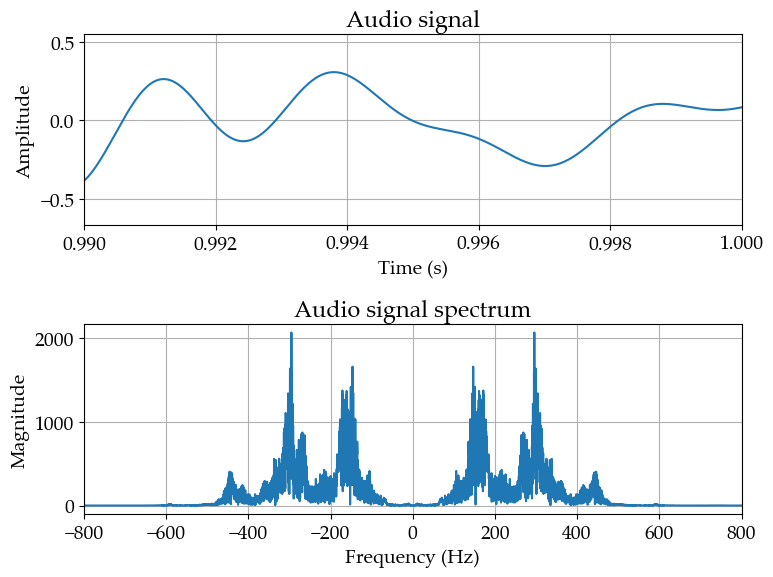

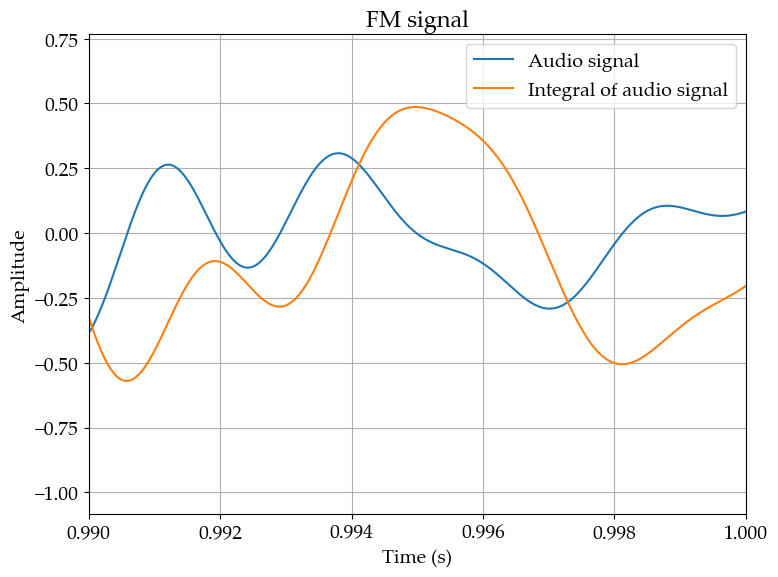

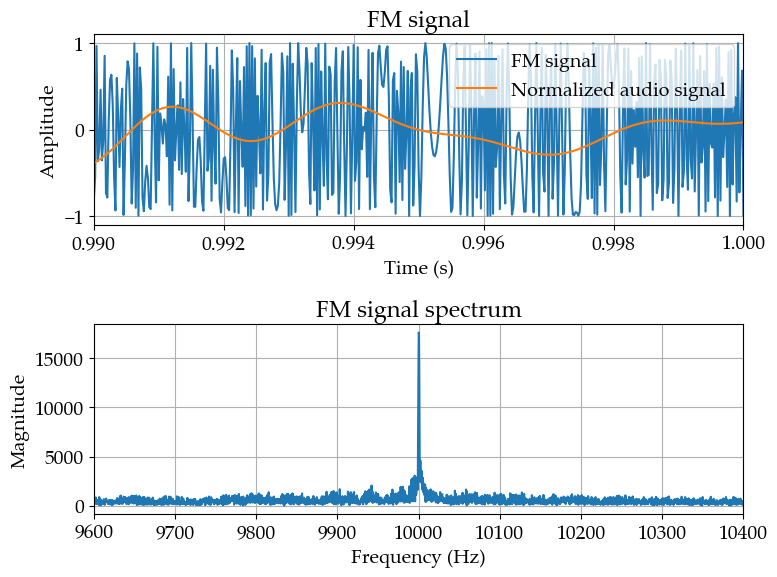

In [104]:
# plot audio signal and its fft
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, message)
plt.title('Audio signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(message))))
plt.title('Audio signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-2*bw, 2*bw)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot fm signal phase
plt.figure()
plt.plot(t, message, label='Audio signal')
plt.plot(t, integral_of_message_normalized, label='Integral of audio signal')
plt.title('FM signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot fm signal and its fft
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, fm_signal, label='FM signal')
plt.plot(t, message, label='Normalized audio signal')
plt.title('FM signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fm_signal_spectrum))
plt.title('FM signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.xlim(fc - bw, fc + bw)
plt.ylim()
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()


## Add Noise

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


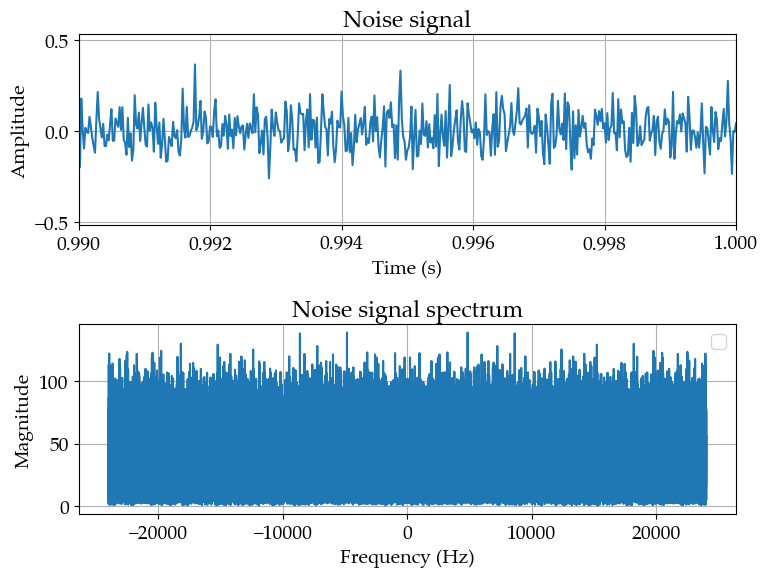

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


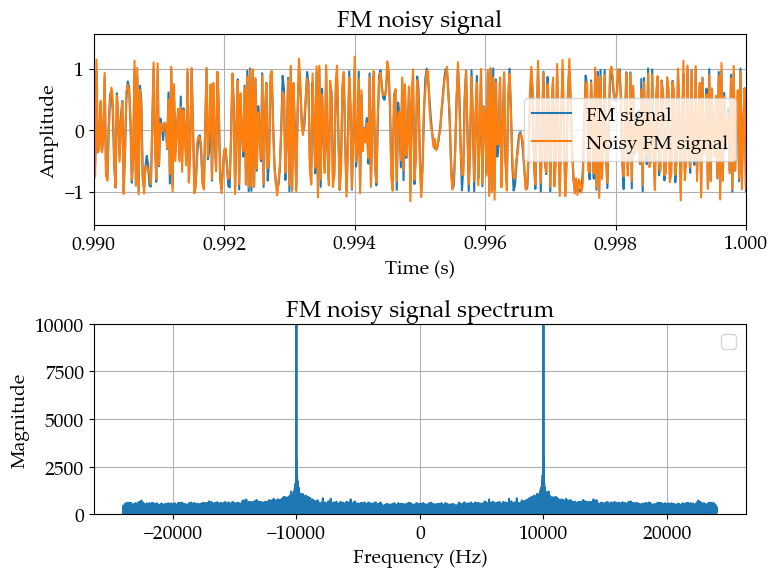

In [89]:
# 3. Add AWGN Noise
noise_power = 0.01  # Noise power
noise = np.sqrt(noise_power) * np.random.normal(size=len(t))
fm_noisy_signal = fm_signal + noise

# plot noise signal and its fft
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, noise)
plt.title('Noise signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(noise))))
plt.title('Noise signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

# plot fm noisy signal and its fft
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, fm_signal, label='FM signal')
plt.plot(t, fm_noisy_signal, label='Noisy FM signal')
plt.title('FM noisy signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(fm_noisy_signal))))
plt.title('FM noisy signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 10000)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


## Demodulation

In [101]:
# For simplicity, using the derivative of the phase of the analytical signal
analytic_signal = hilbert(fm_noisy_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) * (fs / (2.0 * np.pi))
demodulated_signal = np.insert(instantaneous_frequency, 0, 0)  # Add a value for t=0

In [102]:
# Low-pass filter for demodulated signal (for post-detection)
b, a = butter(5, 2 * bw / fs, 'low')  # Low-pass filter with a cutoff at bw Hz
filtered_demodulated_signal = lfilter(b, a, demodulated_signal)

f = np.linspace(-fs/2, fs/2, len(fm_noisy_signal))

# SNR comparison will be performed next.
fm_signal, fm_noisy_signal, demodulated_signal, filtered_demodulated_signal

# extract the demodulated signal
demodulated_signal = np.diff(instantaneous_phase) * (fs / (2.0 * np.pi))
demodulated_signal = np.insert(demodulated_signal, 0, 0)  # Add a value for t=0
demodulated_signal_nodc = demodulated_signal - np.mean(demodulated_signal)  # Remove DC component
# normalize demodulated signal nodc
demodulated_signal_nodc = demodulated_signal_nodc / np.max(np.abs(demodulated_signal_nodc))

print(calculate_max_p2p(demodulated_signal_nodc))
print(calculate_max_p2p(orig_data))

# write the demodulated signal to wav file
wavfile.write('demodulated.wav', fs, demodulated_signal_gain_matched.astype(np.int16))

0.9999998054572669
16412


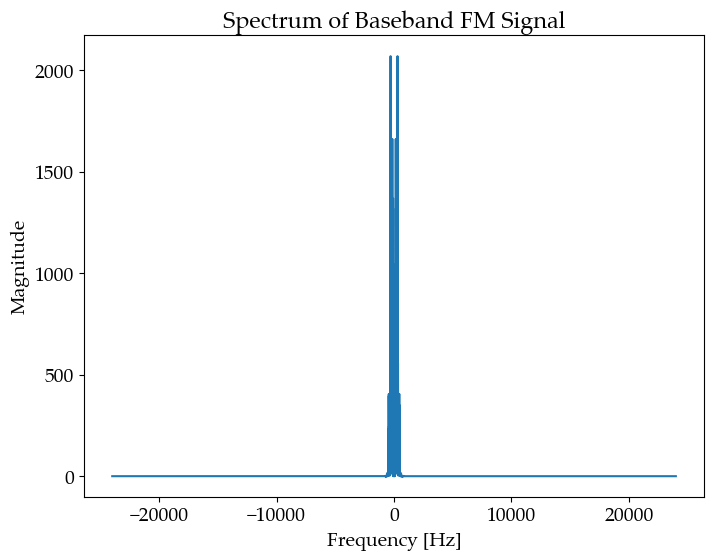

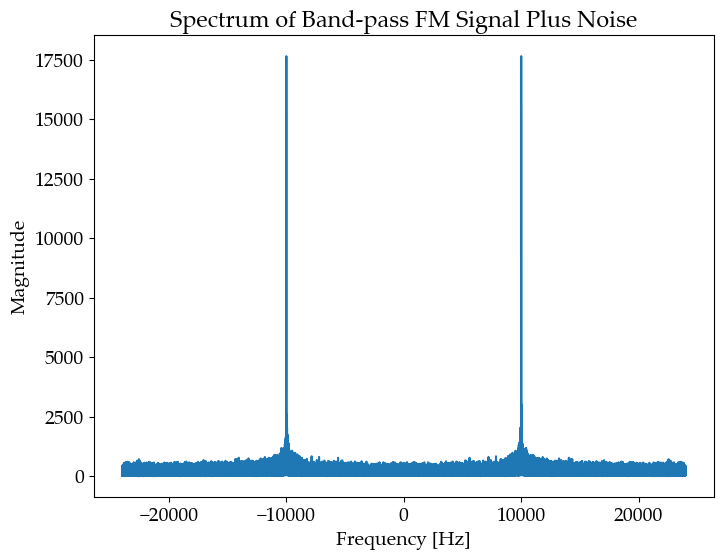

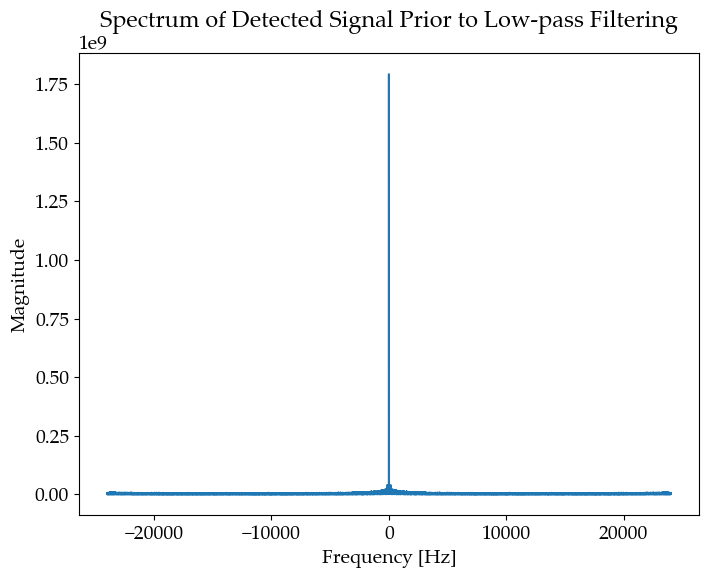

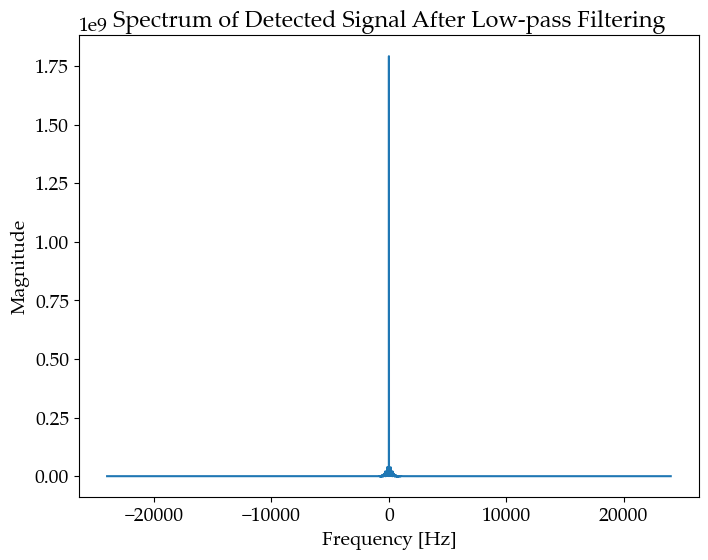

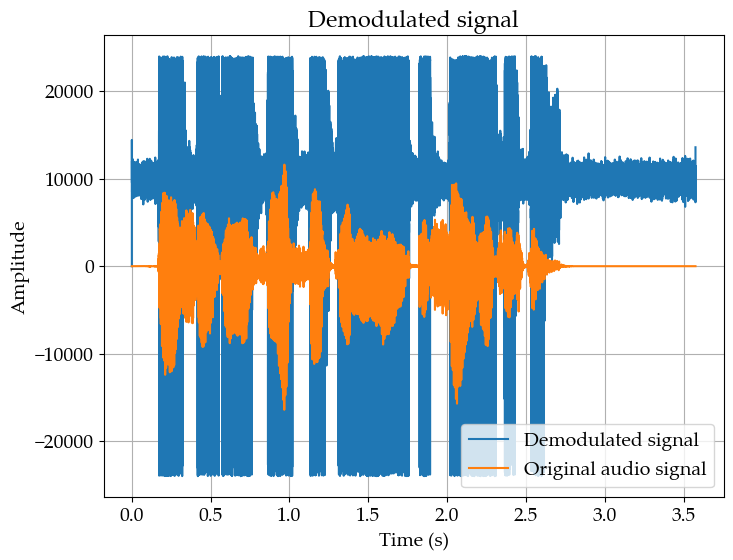

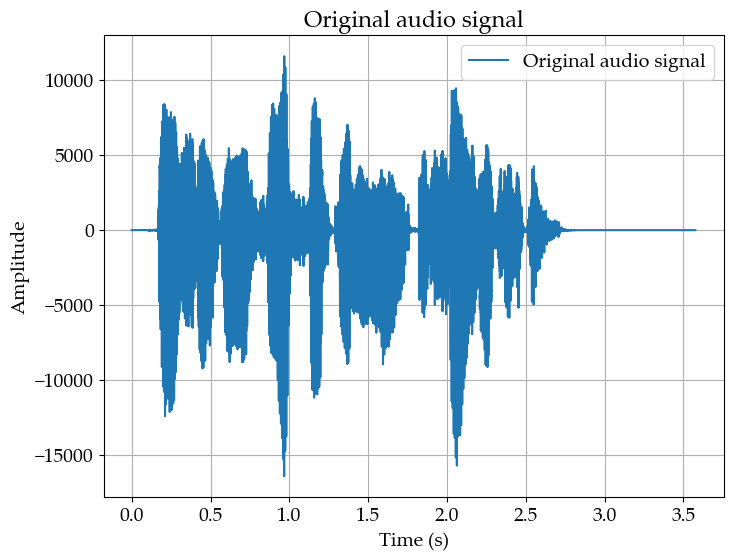

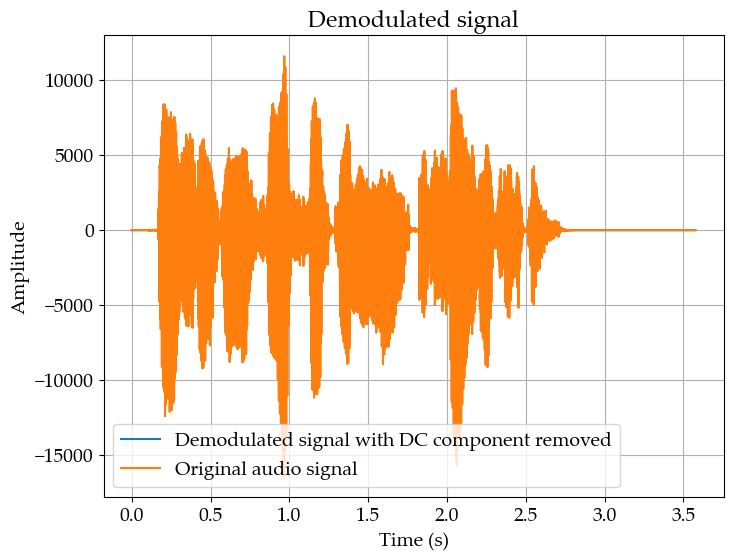

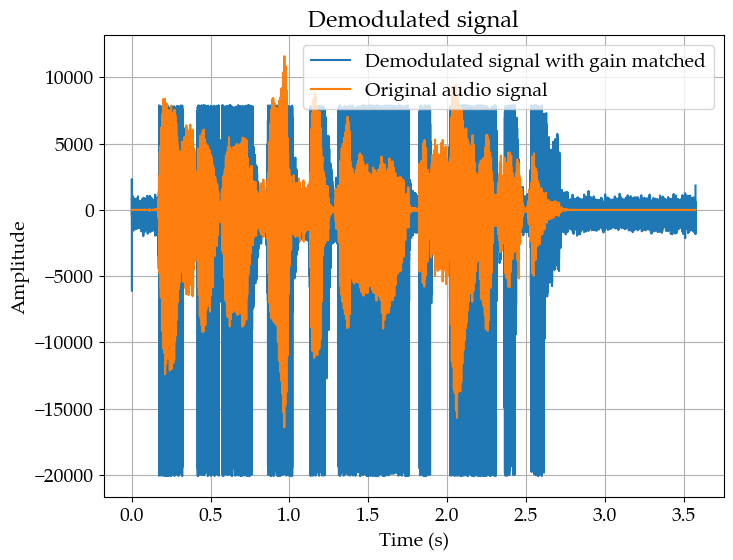

In [103]:
# Spectrum of the baseband FM signal
plt.figure()
baseband_fm_spectrum = fftshift(fft(message))
plt.plot(f, np.abs(baseband_fm_spectrum))
plt.title('Spectrum of Baseband FM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

# Spectrum of the band-pass FM signal plus noise
plt.figure()
bandpass_fm_spectrum = fftshift(fft(fm_noisy_signal))
plt.plot(f, np.abs(bandpass_fm_spectrum))
plt.title('Spectrum of Band-pass FM Signal Plus Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

# Spectrum of the detected signal prior to low-pass filtering
plt.figure()
detected_spectrum_pre_filter = fftshift(fft(demodulated_signal))
plt.plot(f, np.abs(detected_spectrum_pre_filter))
plt.title('Spectrum of Detected Signal Prior to Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

# Spectrum of the detected signal after low-pass filtering
plt.figure()
detected_spectrum_post_filter = fftshift(fft(filtered_demodulated_signal))
plt.plot(f, np.abs(detected_spectrum_post_filter))
plt.title('Spectrum of Detected Signal After Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

# plot the demodulated signal
plt.figure()
plt.plot(t, demodulated_signal, label='Demodulated signal')
plt.plot(t, orig_data, label='Original audio signal')
plt.title('Demodulated signal')
plt.xlabel('Time (s)')
# plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t, orig_data, label='Original audio signal')
plt.title('Original audio signal')
plt.xlabel('Time (s)')
# plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# plot the demodulated signal with dc component removed
plt.figure()
plt.plot(t, demodulated_signal_nodc, label='Demodulated signal with DC component removed')
plt.plot(t, orig_data, label='Original audio signal')
plt.title('Demodulated signal')
plt.xlabel('Time (s)')
# plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# plot the demodulated signal with gain matched with the original signal
plt.figure()
plt.plot(t, demodulated_signal_gain_matched, label='Demodulated signal with gain matched')
plt.plot(t, orig_data, label='Original audio signal')
plt.title('Demodulated signal')
plt.xlabel('Time (s)')
# plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [105]:
# calculate pre and post detection snr
#!! The following code is not correct!!!
pre_detection_snr = 10 * np.log10(np.sum(fm_signal**2) / np.sum(noise**2))
post_detection_snr = 10 * np.log10(np.sum(filtered_demodulated_signal**2) / np.sum(noise**2))
print('Pre-detection SNR: {} dB'.format(pre_detection_snr))
print('Post-detection SNR: {} dB'.format(post_detection_snr))

# calculate the theoretical pre and post detection snr
theoretical_pre_detection_snr = 10 * np.log10((kf * max(message))**2 / noise_power)
theoretical_post_detection_snr = 10 * np.log10((kf * max(message) / (2 * np.pi * bw))**2 / noise_power)
print('Theoretical pre-detection SNR: {} dB'.format(theoretical_pre_detection_snr))
print('Theoretical post-detection SNR: {} dB'.format(theoretical_post_detection_snr))


Pre-detection SNR: 16.963924292374095 dB
Post-detection SNR: 100.63726534498753 dB
Theoretical pre-detection SNR: 61.583624920952495 dB
Theoretical post-detection SNR: -6.421172272769052 dB
